In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylabel
import statsmodels.api as sm
from scipy.stats import nbinom
import numpy as np

TAG_TO_LABEL = {
    "NES": "Cytosol",
    "NLS": "Nuclear",
    "MEM": "Secretory",
    "OMM": "Mitochondria",
}
LABEL_TO_TAG = {
    "Cytosol": "NES",
    "Nuclear": "NLS",
    "Secretory": "MEM",
    "Mitochondria": "OMM",
}

In [2]:
data = {}
dates = ["09/22", "10/28", "11/15"]
for date in dates:
    data[date] = {}
    path_start = f"../data/{date.replace('/','')}/{date.replace('/','')}_"
    data[date]["str_lab"] = pd.read_excel(f"{path_start}str_labels.xlsx", index_col=0)
    data[date]["bin_lab"] = pd.read_excel(f"{path_start}bin_labels.xlsx", index_col=0)
    data[date]["reads"] = pd.read_excel(f"{path_start}reads.xlsx", index_col=0)
    data[date]["reads_edited"] = pd.read_excel(f"{path_start}reads_edited.xlsx", index_col=0)
    data[date]["reads_unedited"] = pd.read_excel(f"{path_start}reads_unedited.xlsx", index_col=0)
    data[date]["editfrac"] = pd.read_excel(f"{path_start}editfrac.xlsx", index_col=0)


# Read counts/edit fraction distributions

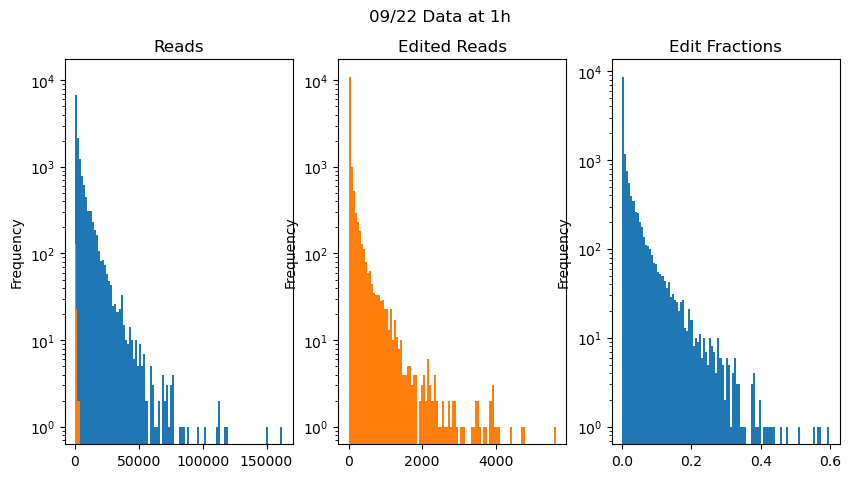

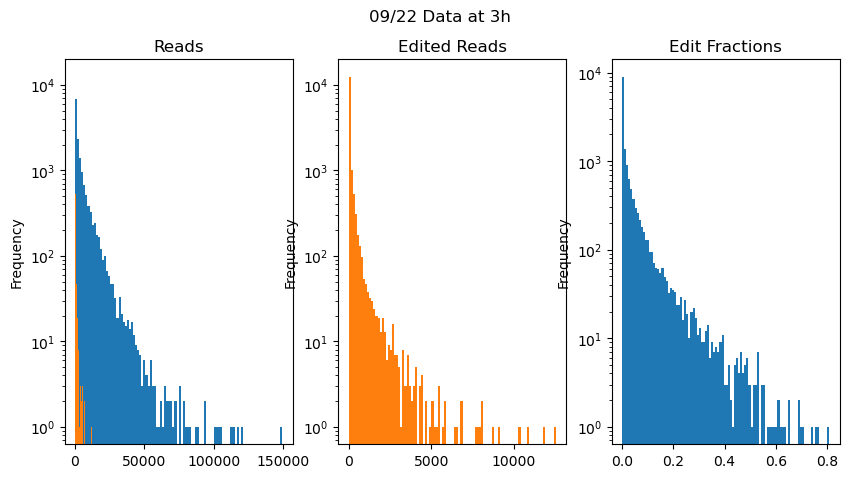

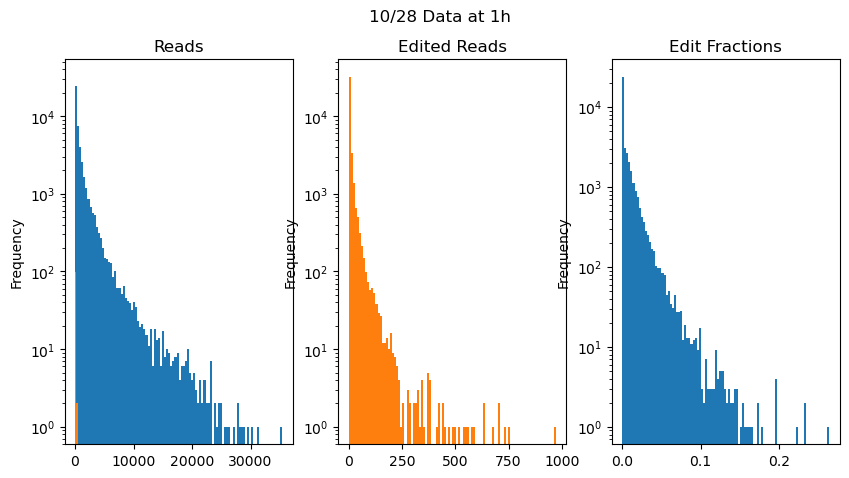

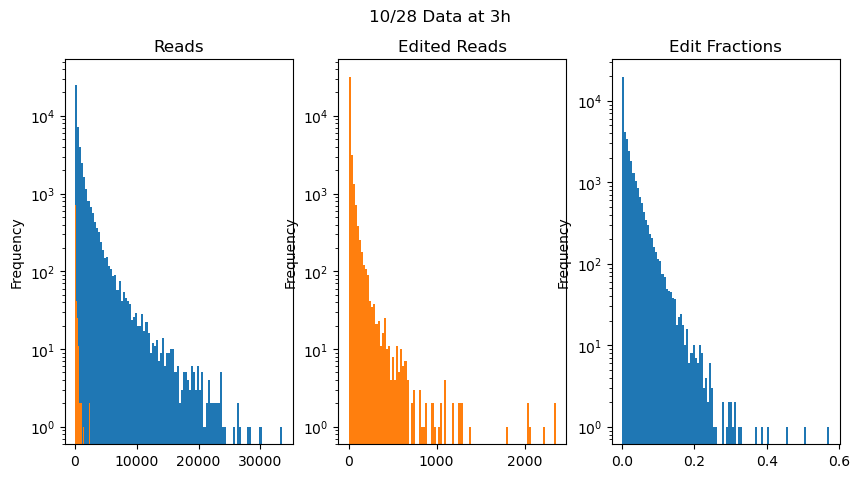

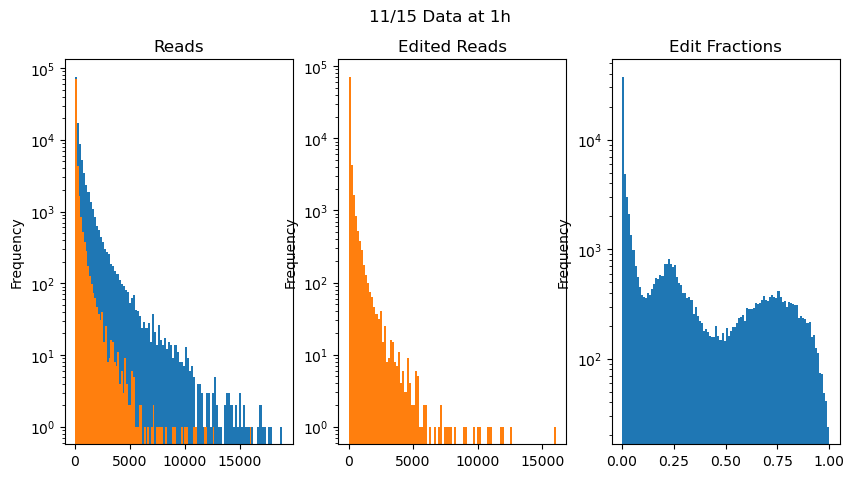

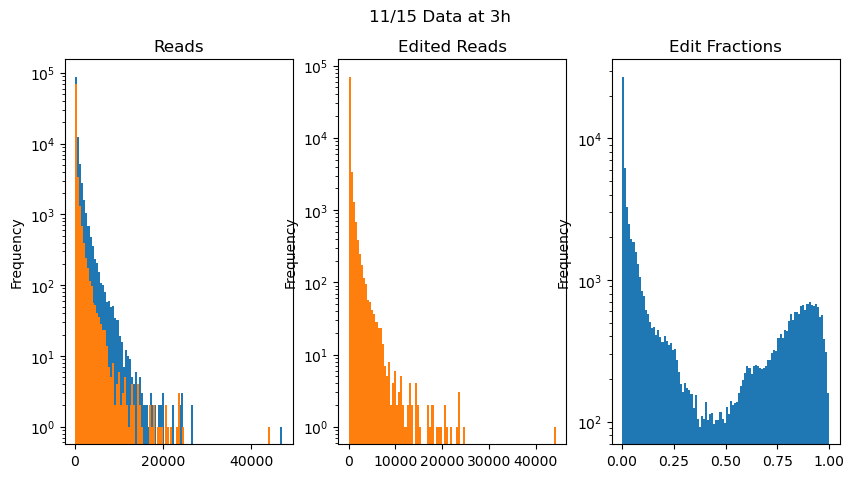

In [14]:
for date in dates:
    for time in ["1h", "3h"]:
        cols = [col for col in data[date]["reads"].columns if time in col.lower() and "REPLICATE" not in col and "CDNA" not in col]
        fig, axs = plt.subplots(1,3,figsize=(10,5))
        plt.suptitle(f"{date} Data at {time}")
        data[date]["reads"][cols].stack().plot.hist(ax=axs[0], bins=100)
        data[date]["reads"][cols].mul(data[date]["editfrac"][cols]).stack().plot.hist(ax=axs[0], bins=100, logy=True)
        data[date]["reads"][cols].mul(data[date]["editfrac"][cols]).stack().plot.hist(ax=axs[1], bins=100, logy=True, color=["#ff7f0e"])
        axs[0].set_title('Reads')
        axs[1].set_title('Edited Reads')
        data[date]["editfrac"][cols].stack().plot.hist(ax=axs[2], bins=100, logy=True)
        axs[2].set_title('Edit Fractions')


# Negative Binomial Read Checks

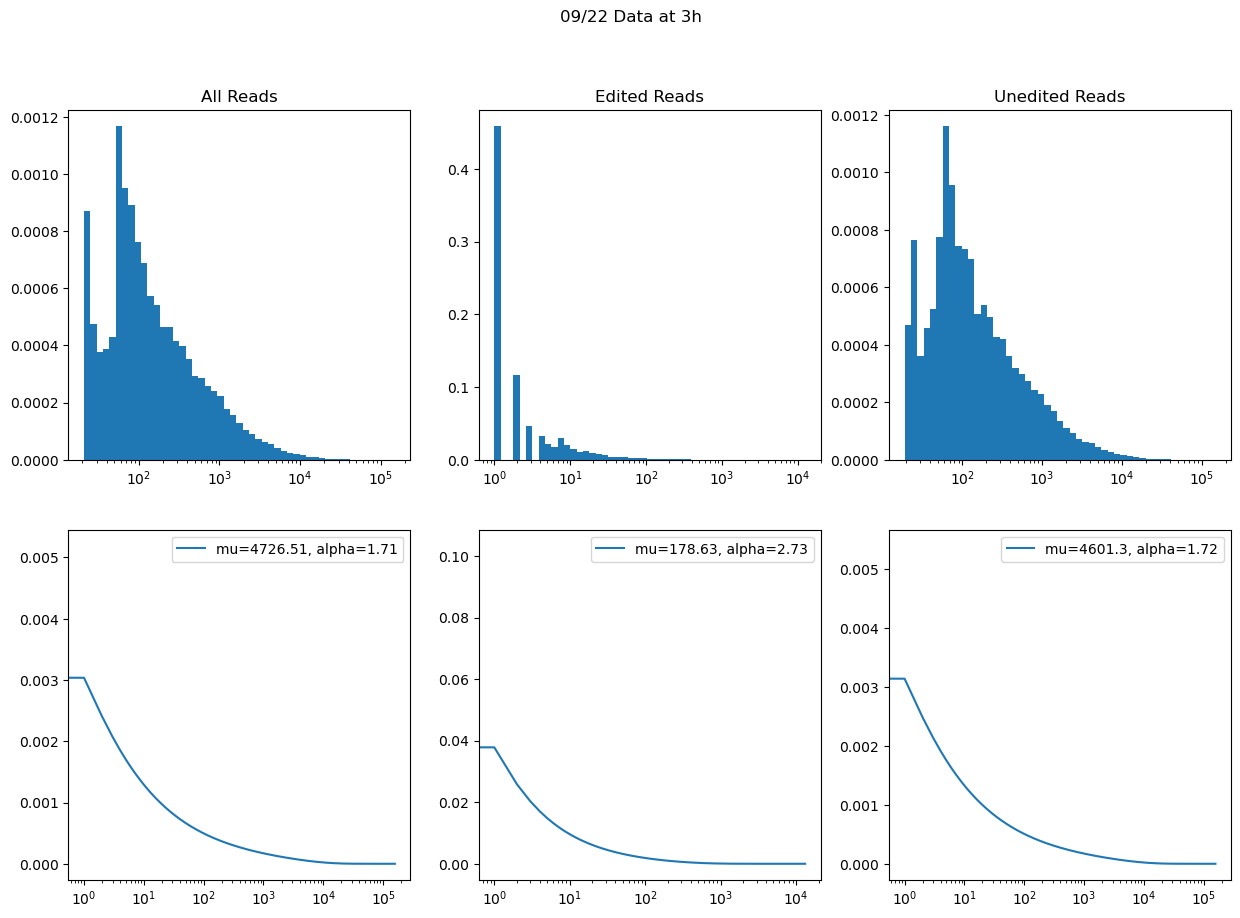

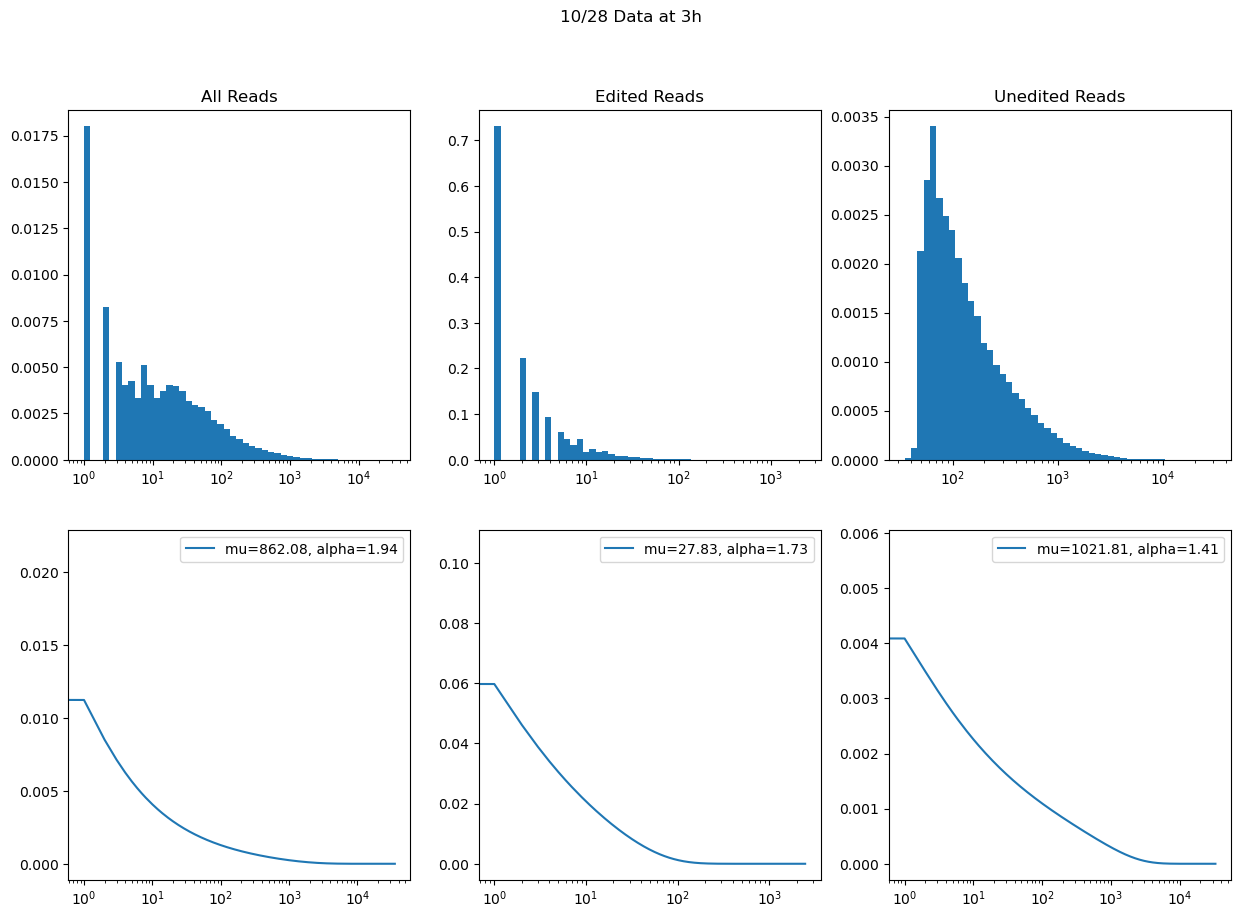

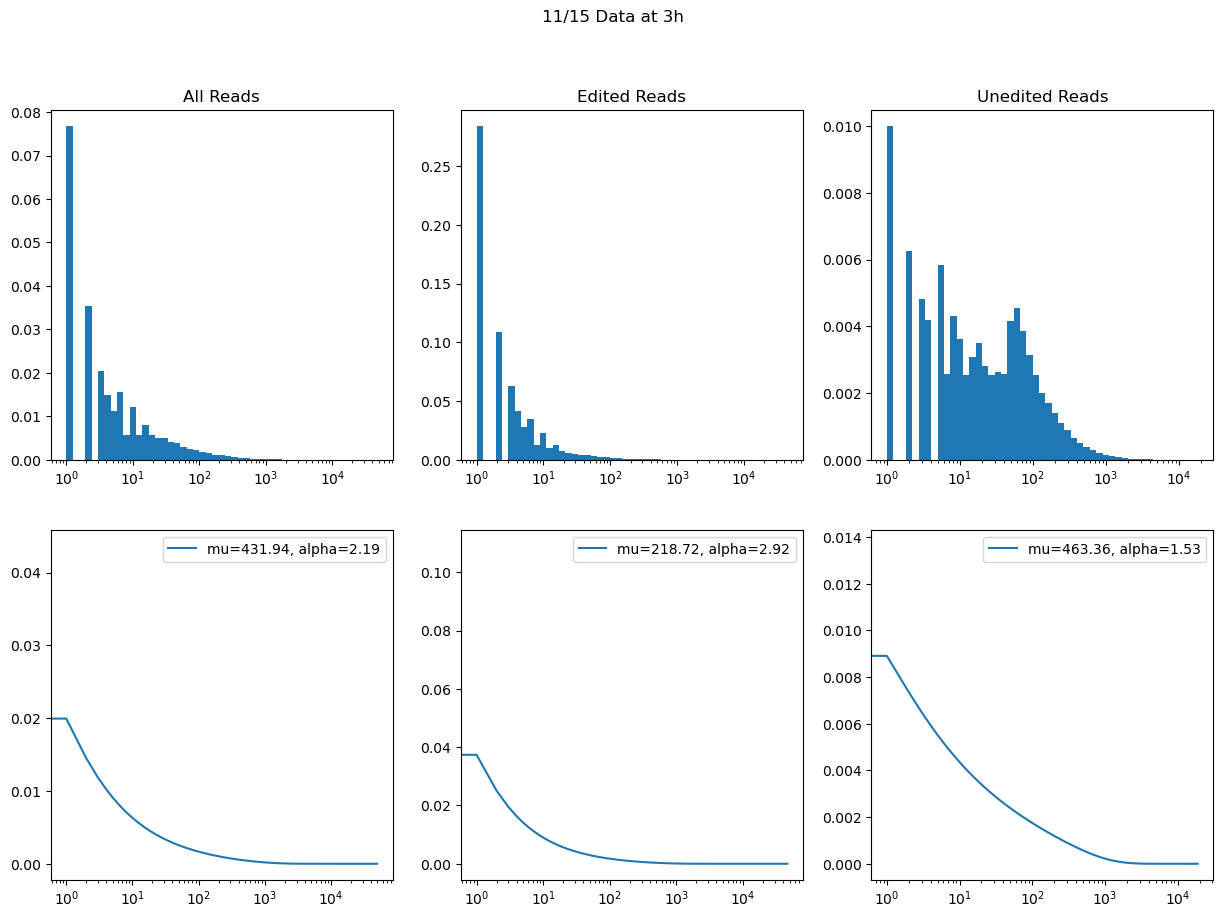

In [45]:
time = "3h"
for date in dates:
    cols = [
        col
        for col in data[date]["reads"].columns
        if time in col.lower() and "REPLICATE" not in col and "CDNA" not in col
    ]
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    plt.suptitle(f"{date} Data at {time}")

    for i, read_type in enumerate(["reads", "reads_edited", "reads_unedited"]):
        reads_stack = data[date][read_type][cols].stack()
        reads_stack = reads_stack[reads_stack > 0]
        # axs[0][i].hist(reads_stack, bins = 100, density=True)
        logbins = np.geomspace(reads_stack.min(), reads_stack.max(), 50)
        axs[0][i].hist(reads_stack, bins = logbins, density=True)

        res = sm.NegativeBinomial(reads_stack, np.ones_like(reads_stack)).fit(
            start_params=[1, 1], disp=False
        )
        mu = np.exp(res.params[0])
        alpha = res.params[1]
        p = 1 / (1 + mu * alpha)
        n = mu * p / (1 - p)
        x_min, x_max = axs[0][i].get_xlim()
        x_plot = np.arange(round(x_min), round(x_max))
        axs[1][i].plot(x_plot, nbinom.pmf(x_plot, n, p), label = f"mu={round(mu,2)}, alpha={round(alpha,2)}")

        axs[0][i].set_xscale("log")
        axs[1][i].set_xscale("log")
        # axs[0][i].set_yscale("log")
        # axs[1][i].set_yscale("log")
        axs[1][i].legend()

    axs[0][0].set_title("All Reads")
    axs[0][1].set_title("Edited Reads")
    axs[0][2].set_title("Unedited Reads")


In [12]:
def NB_plots_per_tag(data, time: str, date: str):

    for tag in TAG_TO_LABEL:
        cols = [
            col
            for col in data[date]["reads"].columns
            if time in col.lower()
            and tag in col
            and "REPLICATE" not in col
            and "CDNA" not in col
        ]
        _, axs = plt.subplots(2, 3, figsize=(15, 10))
        plt.suptitle(f"{date} ABE-{tag} Data at {time}")

        for i, read_type in enumerate(["reads", "reads_edited", "reads_unedited"]):
            reads_stack = data[date][read_type][cols].stack()
            logbins = np.geomspace(max(reads_stack.min(),1), reads_stack.max(), 50)
            axs[0][i].hist(reads_stack, bins=logbins, density=True)

            res = sm.NegativeBinomial(reads_stack, np.ones_like(reads_stack)).fit(
                start_params=[1, 1], disp=False
            )
            mu = np.exp(res.params[0])
            alpha = res.params[1]
            p = 1 / (1 + mu * alpha)
            n = mu * p / (1 - p)
            x_min, x_max = axs[0][i].get_xlim()
            x_plot = np.arange(round(x_min), round(x_max))
            axs[1][i].plot(
                x_plot,
                nbinom.pmf(x_plot, n, p),
                label=f"mu={round(mu,2)}, alpha={round(alpha,2)}",
            )

            axs[0][i].set_xscale("log")
            axs[1][i].set_xscale("log")

            axs[1][i].legend()

        axs[0][0].set_title("All Reads")
        axs[0][1].set_title("Edited Reads")
        axs[0][2].set_title("Unedited Reads")


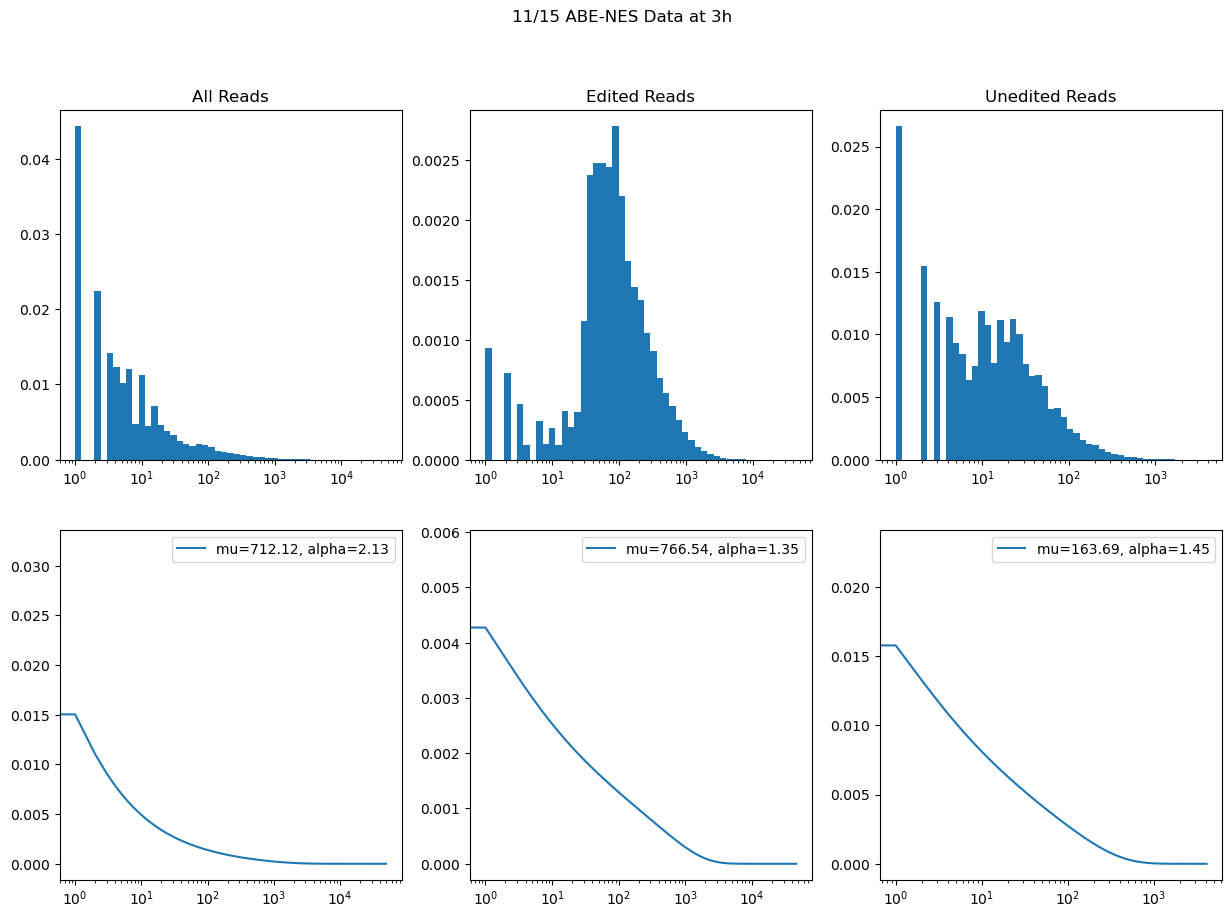

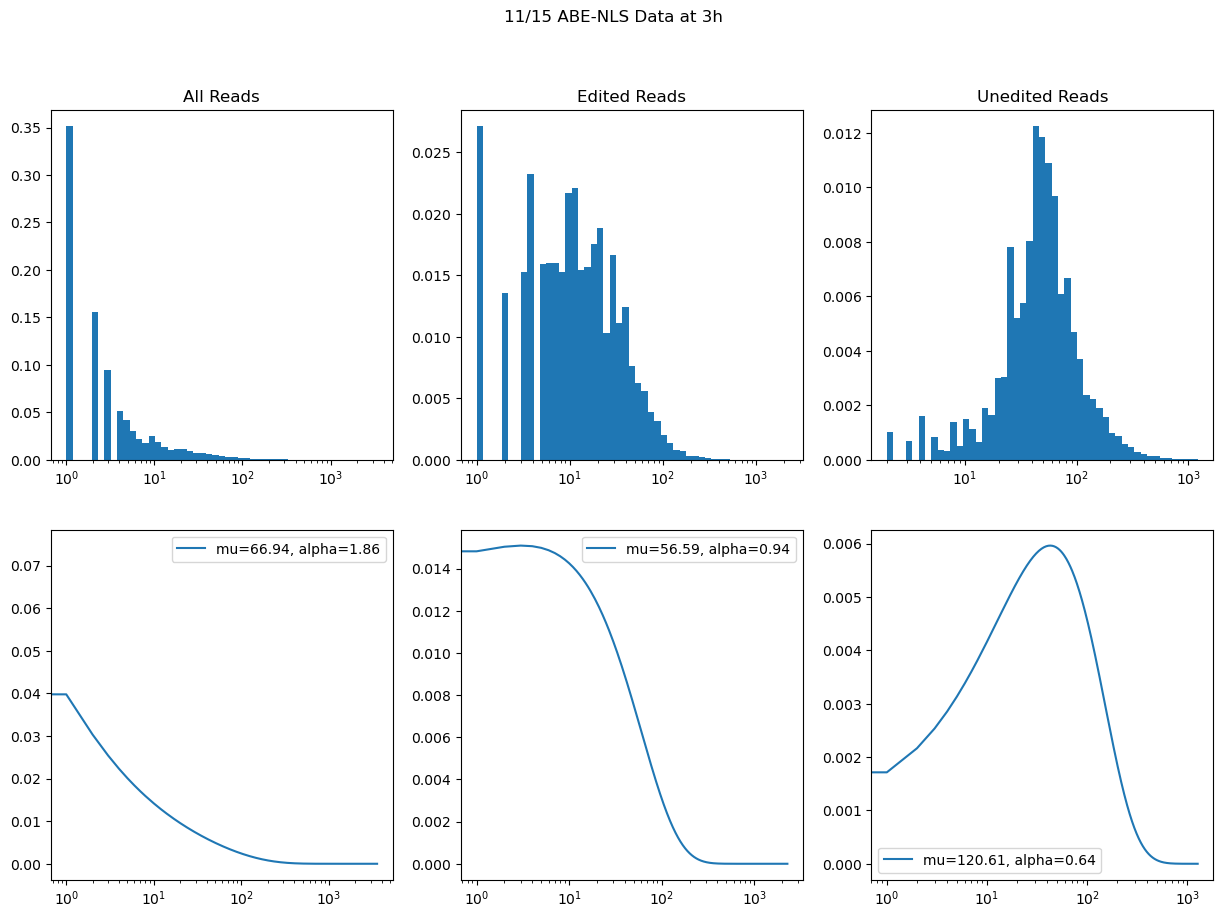

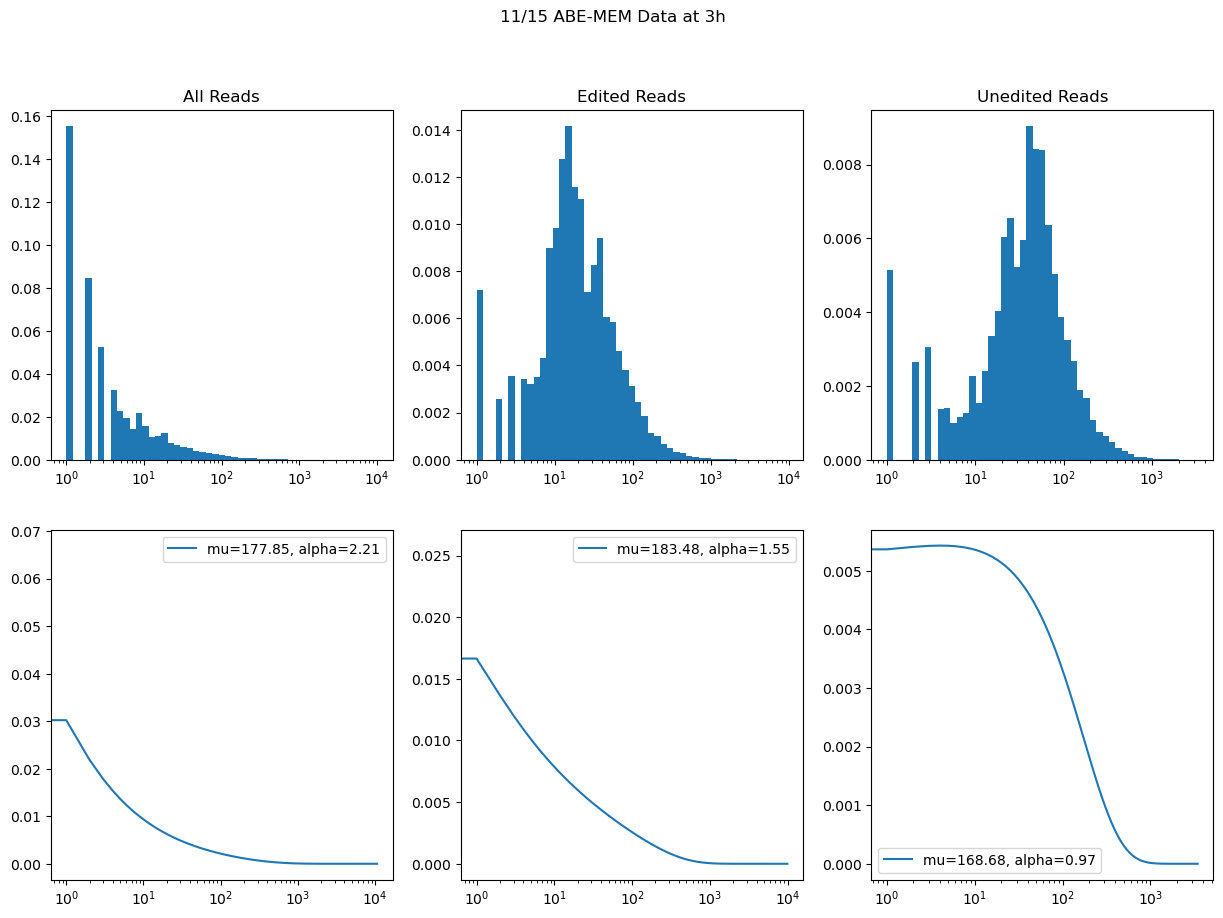

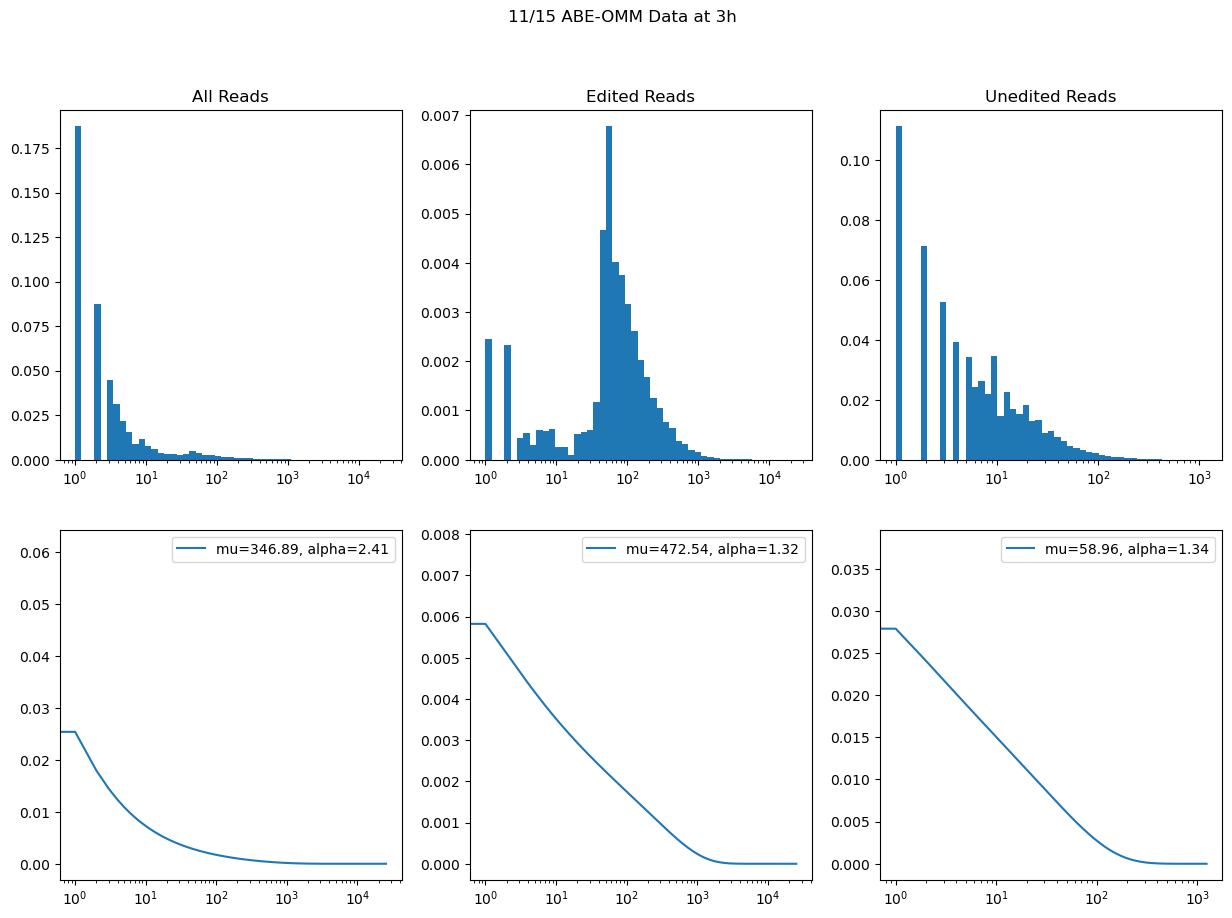

In [14]:
NB_plots_per_tag(data, "3h", "11/15")